# Tensor parallelism

输入数据 x: 形状为 (batch_size, input_dim)

权重矩阵 w: 形状为 (input_dim, output_dim)

预测输出 y_pred: 形状为 (batch_size, output_dim)

真实标签 y_label: 形状为 (batch_size, output_dim)

`y_pred = x * w`


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

bs = 2  # batch size
row = dim = 2  # input dimension
col = out_dim = 4  # output dimension

# 创建输入数据和权重矩阵
x = torch.arange(bs * dim, dtype=torch.float32).reshape(bs, dim)
w = torch.arange(dim * out_dim, dtype=torch.float32, requires_grad=True).reshape(dim, out_dim)

# 随机生成标签数据
y_label = torch.randn(bs, out_dim)

In [5]:
# 自动计算梯度
w.retain_grad()  # 显式地保存非叶节点的梯度
w.grad = None
mse_loss = nn.MSELoss(reduction='mean')

y_pred = x @ w  # @, 矩阵乘法运算符，等价于 torch.matmul()
loss_torch = mse_loss(y_pred, y_label)
loss_torch.backward()
print("PyTorch计算的损失值:", loss_torch)
print("PyTorch计算的梯度:\n", w.grad)

# 手动计算梯度
y_pred = x @ w
delta_y = y_pred - y_label
delta_w = x.t() @ delta_y / out_dim
print("手动计算的梯度:\n", delta_w)

PyTorch计算的损失值: tensor(214.7401, grad_fn=<MseLossBackward0>)
PyTorch计算的梯度:
 tensor([[ 6.2832,  8.2867, 10.7909, 13.3507],
        [10.5525, 13.7490, 16.7911, 21.8384]])
手动计算的梯度:
 tensor([[ 6.2832,  8.2867, 10.7909, 13.3507],
        [10.5525, 13.7490, 16.7911, 21.8384]], grad_fn=<DivBackward0>)


# 张量并行

将权重矩阵按行分割到不同设备上计算，有 行并行(Row-Tensor Parallelism) 和 列并行(Col-Tensor Parallelism)。

- 张量并行的目的：通过将大矩阵分割到不同设备上计算，解决单个设备内存不足的问题，同时利用多设备并行计算提高效率。
- 两种并行方式：
  - 行并行：将权重矩阵按行分割，每个设备计算部分结果，最后相加得到完整输出
  - 列并行：将权重矩阵按列分割，每个设备计算部分输出特征
- 梯度计算验证：
  - 在并行实现中，梯度计算也被相应地分割，最后合并得到完整梯度
- 实际应用：
  - 这种技术在大模型训练中非常有用，如GPT-3等模型就采用了类似的并行策略
  - 可以扩展到更多设备上的分割，不限于2-way分割

张量并行的核心是利用矩阵乘法的分块计算特性。例如，对于矩阵乘法 $Y = XW$：

- 若将权重矩阵 $W$ **按行分块**（行并行）：
$$
W = \begin{bmatrix} W_1 \\ W_2 \end{bmatrix}, \quad Y = XW = X \begin{bmatrix} W_1 \\ W_2 \end{bmatrix} = X_1W_1 + X_2W_2
$$

其中 $X$ 也按列分块为 $[X_1, X_2]$，每个设备计算一部分结果，最后通过求和合并。

- 若将 $W$ **按列分块**（列并行）：
$$
W = [W_1, W_2], \quad Y = XW = [XW_1, XW_2]
$$

每个设备独立计算输出的一个子矩阵，最后拼接结果。

根据实际需求选择行/列并行：
- **行并行**：将FFN层的权重矩阵 $W_{ffn} \in \mathbb{R}^{d_{\text{model}} \times 4d_{\text{model}}}$ 按行分到8个设备，每个设备计算 $\frac{1}{8}$ 的输出。
- **列并行**：将注意力头的 $W_q, W_k, W_v$ 按列分到不同设备，每个设备生成部分注意力特征。

- 优先行分块：当需要合并计算结果（如FFN层、注意力头的输出求和）。行并行需要 All-Reduce（求和）合并部分结果
- 优先列分块：当需要保留输出独立性（如多头注意力）。列并行需要 All-Gather（拼接）最终的输出特征。
- 考虑通信开销：最终选择需通过实际 profiling 确定（如 Megatron-LM 的自动切分策略）。


In [7]:
# 将权重矩阵按行分成两部分
row_dim = dim // 2
w_row_1 = w[:row_dim, :]  # 上半部分
w_row_2 = w[row_dim:, :]  # 下半部分

# 对应的输入数据分割
x_col_1 = x[:, :row_dim]
x_col_2 = x[:, row_dim:]

# 并行计算各部分输出
y_1 = x_col_1 @ w_row_1
y_2 = x_col_2 @ w_row_2

# 合并结果并计算梯度
delta_y = (y_1 + y_2 - y_label)
grad_row_1 = x_col_1.t() @ delta_y 
grad_row_2 = x_col_2.t() @ delta_y 

# 合并梯度
grad_row = torch.cat((grad_row_1, grad_row_2), dim=0) / out_dim
print("行并行计算的梯度:\n", grad_row)

行并行计算的梯度:
 tensor([[ 6.2832,  8.2867, 10.7909, 13.3507],
        [10.5525, 13.7490, 16.7911, 21.8384]], grad_fn=<DivBackward0>)


In [8]:
# 将权重矩阵按列分成两部分
col_dim = out_dim // 2
w_col_1 = w[:, :col_dim]  # 左半部分
w_col_2 = w[:, col_dim:]  # 右半部分

# 并行计算各部分输出
y_1 = x @ w_col_1
y_2 = x @ w_col_2

# 计算各部分的误差
y_1_delta = y_1 - y_label[:, :col_dim]
y_2_delta = y_2 - y_label[:, col_dim:]

# 计算各部分的梯度
grad_col_1 = x.t() @ y_1_delta
grad_col_2 = x.t() @ y_2_delta 

# 合并梯度
grad_col = torch.cat((grad_col_1, grad_col_2), dim=1) / out_dim
print("列并行计算的梯度:\n", grad_col)

列并行计算的梯度:
 tensor([[ 6.2832,  8.2867, 10.7909, 13.3507],
        [10.5525, 13.7490, 16.7911, 21.8384]], grad_fn=<DivBackward0>)


# 理解 AutoGrad 和 计算图

自动微分(Automatic Differentiation)系统和计算图可视化

定义 `Value` 类，这是实现自动微分的核心类，表示计算图中的节点。

关键属性：
- `data`: 存储节点的值
- `grad`: 存储梯度值
- `_backward`: 反向传播函数
- `_prev`: 前驱节点（该节点的输入）
- `_op`: 产生该节点的操作类型
- `label`: 节点标签（用于可视化）

实现的操作：
- `__add__`: 加法运算
- `__mul__`: 乘法运算
- `tanh`: 双曲正切激活函数
- `backward`: 反向传播方法


In [9]:
!pip install graphviz

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/


In [10]:
# 可视化计算图的函数

from graphviz import Digraph


def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [11]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class Value:
    """实现自动微分的Value类"""

    def __init__(self, data, _children=(), _op='', label=''):
        """
        初始化一个可微分的标量值

        参数:
            data: 存储的数值
            _children: 生成此节点的子节点集合(默认为空元组)
            _op: 产生此节点的操作类型(如'+', '*', 'tanh'等)
            label: 节点标签(用于可视化)
        """
        self.data = data      # 存储的数值
        self.grad = 0.0       # 梯度值，初始为0
        self._backward = lambda: None  # 反向传播函数，初始为空操作
        self._prev = set(_children)  # 前驱节点(计算图的输入节点)
        self._op = _op       # 产生此节点的操作类型
        self.label = label    # 节点标签(用于可视化)

    def __repr__(self):
        """返回值的字符串表示"""
        return f"Value(data={self.data})"

    def __add__(self, other):
        """实现加法运算，并定义反向传播规则"""
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            # 加法反向传播：梯度均匀分配给两个输入
            self.grad += 1.0 * out.grad    # ∂out/∂self = 1
            other.grad += 1.0 * out.grad   # ∂out/∂other = 1
        out._backward = _backward
    
        return out

    def __mul__(self, other):
        """实现乘法运算，并定义反向传播规则"""
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            # 乘法反向传播：梯度乘以另一个输入的值
            self.grad += other.data * out.grad    # ∂out/∂self = other.data
            other.grad += self.data * out.grad     # ∂out/∂other = self.data
        out._backward = _backward

        return out

    def tanh(self):
        """实现双曲正切函数，并定义反向传播规则"""
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)  # tanh(x) = (e^2x - 1)/(e^2x + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            # tanh反向传播：梯度乘以(1 - tanh²(x))
            self.grad += (1 - t**2) * out.grad  # ∂tanh(x)/∂x = 1 - tanh²(x)
        out._backward = _backward

        return out

    def backward(self):
        """执行反向传播算法，计算所有前驱节点的梯度"""

        # 1. 构建拓扑排序
        topo = []       # 拓扑排序结果
        visited = set() # 已访问节点集合

        def build_topo(v):
            """递归构建拓扑排序(深度优先搜索)"""
            if v not in visited:
                visited.add(v)
                for child in v._prev:  # 先处理前驱节点
                    build_topo(child)
                topo.append(v)         # 后序添加当前节点

        build_topo(self)  # 从当前节点开始构建拓扑排序

        # 2. 反向传播计算梯度
        self.grad = 1.0  # 输出节点梯度初始为1.0 (∂L/∂L = 1)

        # 按拓扑排序的逆序处理每个节点
        for node in reversed(topo):
            node._backward()  # 调用每个节点的反向传播函数

In [16]:
# 前向计算
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

e = a * b
e.label = 'e'

d = e + c
d.label = 'd'

f = Value(-2.0, label='f')
L = d * f
L.label = 'L'
print(L)

draw_dot(L)

Value(data=-8.0)
-8.0


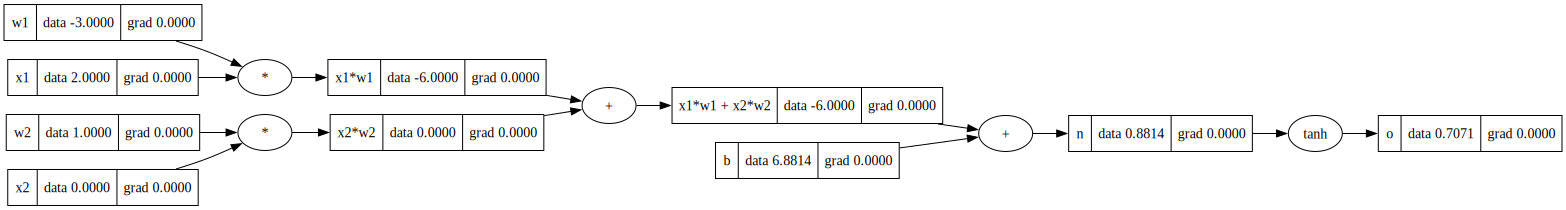

In [17]:
# NN forward

# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1
x1w1.label = 'x1*w1'

x2w2 = x2*w2
x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b
n.label = 'n'

o = n.tanh()
o.label = 'o'

draw_dot(o)

In [24]:
# Backward
o.backward()
visited = set()

topo = []
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

build_topo(o)
print("topo:")
for node in topo:
    print(node)


Value(data=2.0)
Value(data=-3.0)
Value(data=-6.0)
Value(data=0.0)
Value(data=1.0)
Value(data=0.0)
Value(data=-6.0)
Value(data=6.881373587019543)
Value(data=0.8813735870195432)
Value(data=0.7071067811865476)


# MLP梯度计算分析

研究多层感知机(MLP)在前向传播和反向传播时的计算量关系，特别是比较单层和多层网络的计算量差异，并通过PyTorch的自动微分功能进行验证。

在神经网络中，反向传播（反向梯度计算）通常比前向传播的计算量更大，主要原因如下：

1. **计算图的存储与回溯**：反向传播需要存储前向传播的所有中间结果用于梯度计算
2. **链式法则的应用**：每个参数的梯度计算都涉及对多个操作的偏导连乘
3. **更复杂的运算**：反向传播中通常包含更多的矩阵运算和转置操作

对于多层网络：
- 前向传播：计算量随层数线性增加
- 反向传播：计算量随层数增加得更快，因为每层都需要计算权重梯度和输入梯度


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import time

# 定义一个2层MLP
class TwoLayerMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TwoLayerMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# 参数设置
input_size = 1000
hidden_size = 500
output_size = 10
batch_size = 32

# 创建模型和输入
model = TwoLayerMLP(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 随机输入和目标
inputs = torch.randn(batch_size, input_size)
targets = torch.randn(batch_size, output_size)

# 前向传播计时
start = time.time()
outputs = model(inputs)
forward_time = time.time() - start

# 反向传播计时
optimizer.zero_grad()
start = time.time()
loss = criterion(outputs, targets)
loss.backward()
backward_time = time.time() - start

print(f"前向传播时间: {forward_time:.6f}秒")
print(f"反向传播时间: {backward_time:.6f}秒")
print(f"反向/前向时间比: {backward_time/forward_time:.2f}")

with torch.autograd.profiler.profile() as prof:
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    
print(prof.key_averages().table(sort_by="self_cpu_time_total"))

前向传播时间: 0.004050秒
反向传播时间: 0.002098秒
反向/前向时间比: 0.52
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                             aten::add_        54.15%     590.573us        54.15%     590.573us     147.643us             4  
                                            aten::addmm        18.21%     198.552us        18.52%     202.010us     101.005us             2  
                                               aten::mm        10.79%     117.688us        10.81%     117.939us      39.313us             3  
                                           aten::linear         8.00%      87.195us        26.97%